# WASP-80b broadband analysis: GP Hyperparameter estimation 

In [2]:
%pylab inline
%run __init__.py

Populating the interactive namespace from numpy and matplotlib


In [5]:
from exotk.utils.misc import fold
from src.extcore import *

lpf = LPFTM()
pv0 = pd.read_hdf(RFILE_EXT,'ckwn/fc').median().values

In [6]:
fluxes_m = lpf.compute_transit(pv0)
residuals = [fo-fm for fo,fm in zip(lpf.fluxes, fluxes_m)]
gps = [GPTime(time, res) for time,res in zip(lpf.times, residuals)]
hps = []

## Light curves

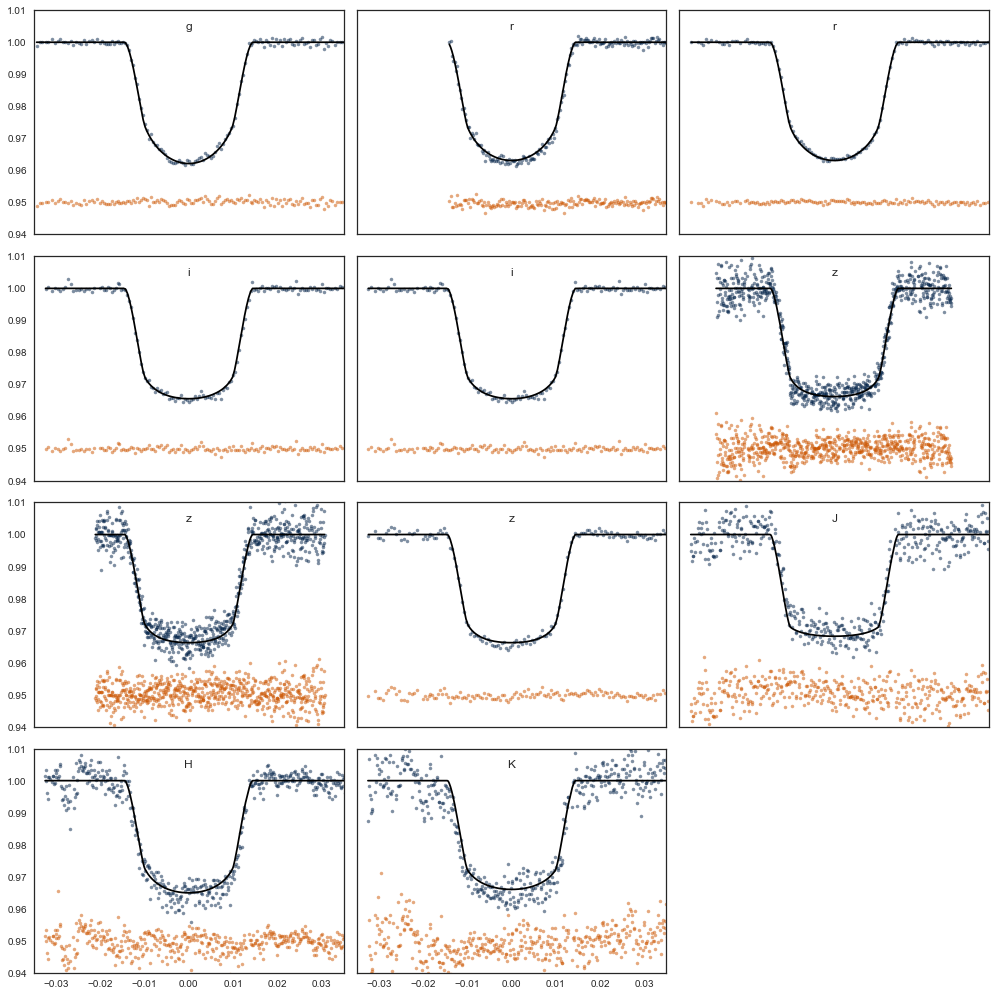

In [8]:
phases = list(map(lambda t: fold(t, P, TC, 0.5)-0.5, lpf.times))
fig,axs = subplots(4,3, figsize=(14,14),sharey=True, sharex=True)
for iax,ilc in enumerate(lpf.lcorder):
    a = axs.flat[iax]
    a.plot(phases[ilc],lpf.fluxes[ilc],'.', alpha=0.5)
    a.plot(phases[ilc],fluxes_m[ilc],'k')
    a.plot(phases[ilc],lpf.fluxes[ilc]-fluxes_m[ilc]+0.95,'.', alpha=0.5)
    a.text(0.5, 0.95, lpf.passbands[ilc], ha='center', va='top', size=12, transform=a.transAxes)
setp(axs, ylim=(0.94,1.01), xlim=(-0.035,0.035))
fig.tight_layout()
axs.flat[-1].set_visible(False)

In [9]:
hps = []
for i,gp in enumerate(gps):
    de = DiffEvol(gp.lnposterior, gp.ps.bounds, 30, maximize=True)
    de._population[:,0] = log10(normal(gp.flux.std(), 2e-1*gp.flux.std(), 30))
    de._population[:,2] = log10(normal(gp.flux.std(), 2e-1*gp.flux.std(), 30))
    de.optimize(25)
    hps.append(gp.fit(de.minimum_location, False))
    clear_output(wait=True)
    display(HTML('{:d} / {:d}'.format(i+1, len(gps))))

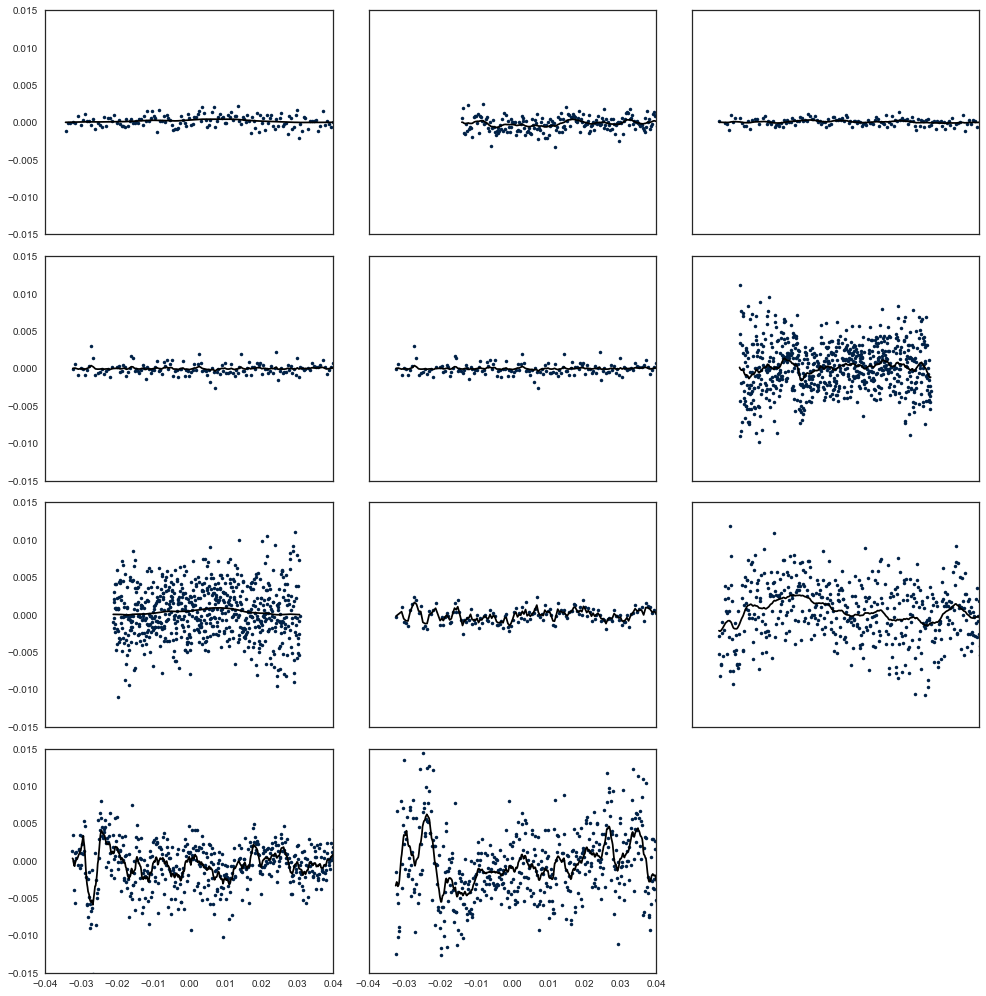

In [13]:
fig,axs = subplots(4,3, figsize=(14,14),sharey=True, sharex=True)
for iax,ilc in enumerate(lpf.lcorder):
    axs.flat[iax].plot(phases[ilc], gps[ilc].flux, '.', alpha=1)
    gps[ilc].compute(hps[ilc])
    pr = gps[ilc].gp.predict(gps[ilc].flux, gps[ilc].inputs, return_cov=False)
    #pr = gps[ilc].predict(hps[ilc])
    axs.flat[iax].plot(phases[ilc], pr, 'k')
setp(axs, ylim=(-0.015,.015), xlim=(-0.04,0.04))
fig.tight_layout()
axs.flat[-1].set_visible(False)

In [15]:
with pd.HDFStore(DFILE_EXT) as f:
    ntr = [k[3:] for k in f.keys() if 'lc/triaud' in k]
    nma = [k[3:] for k in f.keys() if 'lc/mancini' in k]

df = pd.DataFrame(hps, columns=gp.names, index=lpf.passbands)
df['lc_name'] = ntr+nma
df

,log10_amplitude,inverse_time_scale,log10_white_noise,lc_name
r,-3.388060,13129.728869,-3.053310,/triaud2013/r/eulercam_1
z,-3.059929,60262.784072,-2.505448,/triaud2013/z/trappist_1
z,-3.291873,611.259197,-2.459443,/triaud2013/z/trappist_2
H,-2.721652,42262.905297,-2.604146,/mancini2014/H/grond
J,-2.823763,3351.486779,-2.444158,/mancini2014/J/grond
K,-2.547208,17517.144191,-2.378592,/mancini2014/K/grond
g,-3.607916,319.935697,-3.127402,/mancini2014/g/grond
i,-3.590374,499999.999996,-3.149442,/mancini2014/i/dfosc
i,-3.590373,499999.999999,-3.149442,/mancini2014/i/grond
r,-3.752541,10888.239235,-3.367586,/mancini2014/r/grond


In [16]:
df.ix[:3].to_hdf(RFILE_EXT, 'gphp/triaud2013')
df.ix[3:].to_hdf(RFILE_EXT, 'gphp/mancini2014')

---

<center> &copy; 2017 <a href="mailto:hannu@iac.es">Hannu Parviainen</a></center>